In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../data_in/CE_Crateus.csv'
data_output_path = '../data_out/weather.csv'
data_output_path_npsave = '../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

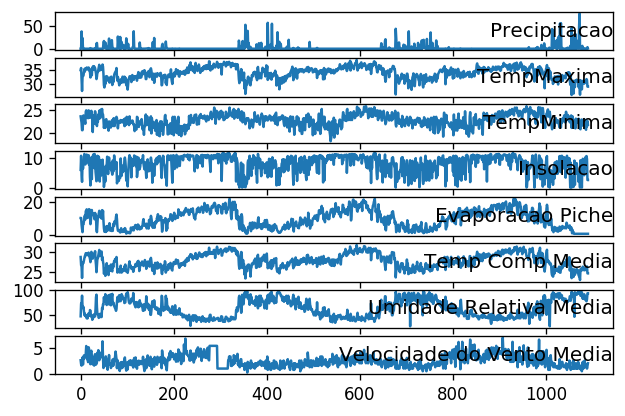

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return (x_train, y_train, x_test, y_test)

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return model

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler * inv_y_hat
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler * inv_y_test
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# calculate metrics
def metrics(model, x_test, y_test, scaler):
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    rmse = sqrt(mean_squared_error(inv_y_test, inv_y_hat))
    variance = explained_variance_score(inv_y_test, inv_y_hat)
    maxError = np.abs(inv_y_test - inv_y_hat)
    meanAbsolutError = mean_absolute_error(inv_y_test, inv_y_hat)
    medianAbsoluteError = np.abs(inv_y_test - inv_y_hat)
    
    return [rmse, variance, maxError, meanAbsolutError, medianAbsoluteError]

In [11]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    metrics_list = []
    rmse = []
    variance = []
    maxError = []
    meanAbsolutError = []
    medianAbsoluteError = []
    i = len(days_to_predict) - 1
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        model = myLSTM(x_train, y_train, x_test, y_test, scaler)    
        metrics_list += metrics(model, x_test, y_test, scaler)
        
        rmse += [metrics_list[0]]
        variance += [metrics_list[1]]
        maxError += [metrics_list[2]]
        meanAbsolutError += [metrics_list[3]]
        medianAbsoluteError += [metrics_list[4]]
        
        i -= 1
        dataset = dataset[:-1]
        
    print('Test RMSE -------------------------- {:.4}'.format(np.mean(rmse)))
    print('Test VARIANCE ---------------------- {:.4}'.format(np.mean(variance)))
    print('Test MAX-ERROR --------------------- {:.4}'.format(np.max(maxError)))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(np.mean(meanAbsolutError)))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(np.median((medianAbsoluteError))))

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 0s - loss: 1.0483 - mean_squared_error: 1.4006 - val_loss: 0.3651 - val_mean_squared_error: 0.1840
Epoch 2/1000
 - 0s - loss: 0.3158 - mean_squared_error: 0.1358 - val_loss: 0.2103 - val_mean_squared_error: 0.0450
Epoch 3/1000
 - 0s - loss: 0.0935 - mean_squared_error: 0.0134 - val_loss: 0.1654 - val_mean_squared_error: 0.0503
Epoch 4/1000
 - 0s - loss: 0.0695 - mean_squared_error: 0.0078 - val_loss: 0.0966 - val_mean_squared_error: 0.0150
Epoch 5/1000
 - 0s - loss: 0.0635 - mean_squared_error: 0.0067 - val_loss: 0.1088 - val_mean_squared_error: 0.0199
Epoch 6/1000
 - 0s - loss: 0.0619 - mean_squared_error: 0.0063 - val_loss: 0.0958 - val_mean_squared_error: 0.0175
Epoch 7/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0062 - val_loss: 0.1011 - val_mean_squared_error: 0.0203
Epoch 8/1000
 - 0s - loss: 0.0615 - mean_squared_error: 0.0062 - val_loss: 0.0970 - val_mean_squared_error: 0.0184
Epoch 9/1000
 - 0s - loss: 0.0599 -

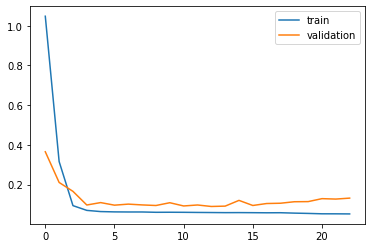


predict: [[30.81669793 21.77704932]]
real:      [[27.59835287 20.91363072]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8417 - mean_squared_error: 0.9558 - val_loss: 0.3743 - val_mean_squared_error: 0.1448
Epoch 2/1000
 - 0s - loss: 0.3484 - mean_squared_error: 0.1427 - val_loss: 0.2227 - val_mean_squared_error: 0.0725
Epoch 3/1000
 - 0s - loss: 0.1628 - mean_squared_error: 0.0378 - val_loss: 0.1250 - val_mean_squared_error: 0.0245
Epoch 4/1000
 - 0s - loss: 0.0813 - mean_squared_error: 0.0110 - val_loss: 0.0562 - val_mean_squared_error: 0.0039
Epoch 5/1000
 - 0s - loss: 0.0628 - mean_squared_error: 0.0064 - val_loss: 0.0560 - val_mean_squared_error: 0.0036
Epoch 6/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0059 - val_loss: 0.0609 - val_mean_squared_error: 0.0038
Epoch 7/1000
 - 0s - loss: 0.0590 - mean_squared_error: 0.0057 - val_loss: 0.0712 - val_mean_squared_error: 0.0051
Epoch 8/1000
 - 0s - loss: 0.0592 - mean_squared_error: 0.0057 - val_los

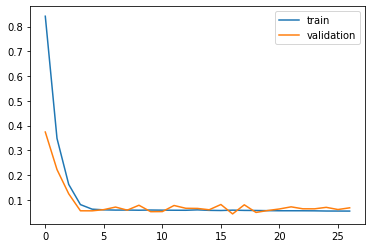


predict: [[30.52329218 21.13955157]]
real:      [[27.59835287 21.67759897]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2543 - mean_squared_error: 0.1592 - val_loss: 0.1788 - val_mean_squared_error: 0.0335
Epoch 2/1000
 - 0s - loss: 0.0800 - mean_squared_error: 0.0108 - val_loss: 0.0324 - val_mean_squared_error: 0.0011
Epoch 3/1000
 - 0s - loss: 0.0647 - mean_squared_error: 0.0070 - val_loss: 0.0395 - val_mean_squared_error: 0.0017
Epoch 4/1000
 - 0s - loss: 0.0633 - mean_squared_error: 0.0065 - val_loss: 0.0495 - val_mean_squared_error: 0.0034
Epoch 5/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0060 - val_loss: 0.0403 - val_mean_squared_error: 0.0016
Epoch 6/1000
 - 0s - loss: 0.0589 - mean_squared_error: 0.0058 - val_loss: 0.0290 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 0s - loss: 0.0576 - mean_squared_error: 0.0056 - val_loss: 0.0423 - val_mean_squared_error: 0.0019
Epoch 8/1000
 - 0s - loss: 0.0575 - mean_squared_error: 0.0055 - val_los

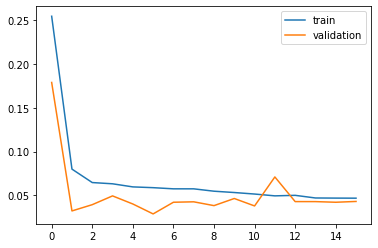


predict: [[30.88778784 21.7250399 ]]
real:      [[29.89025761 20.5316466 ]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7214 - mean_squared_error: 0.6460 - val_loss: 0.2343 - val_mean_squared_error: 0.0613
Epoch 2/1000
 - 0s - loss: 0.1257 - mean_squared_error: 0.0236 - val_loss: 0.0856 - val_mean_squared_error: 0.0104
Epoch 3/1000
 - 0s - loss: 0.0760 - mean_squared_error: 0.0090 - val_loss: 0.0954 - val_mean_squared_error: 0.0107
Epoch 4/1000
 - 0s - loss: 0.0621 - mean_squared_error: 0.0060 - val_loss: 0.1134 - val_mean_squared_error: 0.0129
Epoch 5/1000
 - 0s - loss: 0.0618 - mean_squared_error: 0.0063 - val_loss: 0.0998 - val_mean_squared_error: 0.0103
Epoch 6/1000
 - 0s - loss: 0.0597 - mean_squared_error: 0.0059 - val_loss: 0.1081 - val_mean_squared_error: 0.0117
Epoch 7/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0061 - val_loss: 0.0876 - val_mean_squared_error: 0.0079
Epoch 8/1000
 - 0s - loss: 0.0603 - mean_squared_error: 0.0061 - val_los

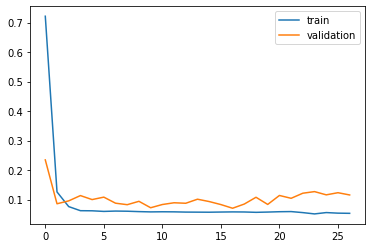


predict: [[29.51009286 21.68665903]]
real:      [[30.27224173 21.86859103]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2432 - mean_squared_error: 0.1067 - val_loss: 0.0880 - val_mean_squared_error: 0.0099
Epoch 2/1000
 - 0s - loss: 0.0843 - mean_squared_error: 0.0109 - val_loss: 0.0552 - val_mean_squared_error: 0.0042
Epoch 3/1000
 - 0s - loss: 0.0705 - mean_squared_error: 0.0079 - val_loss: 0.1116 - val_mean_squared_error: 0.0125
Epoch 4/1000
 - 0s - loss: 0.0693 - mean_squared_error: 0.0076 - val_loss: 0.0862 - val_mean_squared_error: 0.0078
Epoch 5/1000
 - 0s - loss: 0.0627 - mean_squared_error: 0.0064 - val_loss: 0.0704 - val_mean_squared_error: 0.0060
Epoch 6/1000
 - 0s - loss: 0.0624 - mean_squared_error: 0.0063 - val_loss: 0.0682 - val_mean_squared_error: 0.0052
Epoch 7/1000
 - 0s - loss: 0.0619 - mean_squared_error: 0.0061 - val_loss: 0.0700 - val_mean_squared_error: 0.0050
Epoch 8/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0060 - val_los

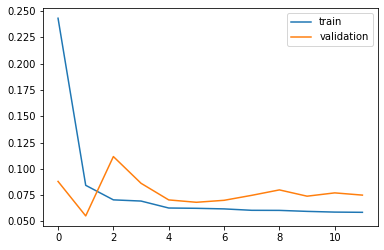


predict: [[30.90390098 21.21721943]]
real:      [[29.60376952 19.86317438]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8394 - mean_squared_error: 1.0258 - val_loss: 0.5456 - val_mean_squared_error: 0.4700
Epoch 2/1000
 - 0s - loss: 0.5116 - mean_squared_error: 0.4685 - val_loss: 0.2504 - val_mean_squared_error: 0.1173
Epoch 3/1000
 - 0s - loss: 0.2088 - mean_squared_error: 0.0944 - val_loss: 0.1735 - val_mean_squared_error: 0.0483
Epoch 4/1000
 - 0s - loss: 0.0805 - mean_squared_error: 0.0117 - val_loss: 0.0964 - val_mean_squared_error: 0.0104
Epoch 5/1000
 - 0s - loss: 0.0672 - mean_squared_error: 0.0073 - val_loss: 0.1044 - val_mean_squared_error: 0.0113
Epoch 6/1000
 - 0s - loss: 0.0617 - mean_squared_error: 0.0061 - val_loss: 0.0875 - val_mean_squared_error: 0.0078
Epoch 7/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0062 - val_loss: 0.0874 - val_mean_squared_error: 0.0099
Epoch 8/1000
 - 0s - loss: 0.0611 - mean_squared_error: 0.0061 - val_los

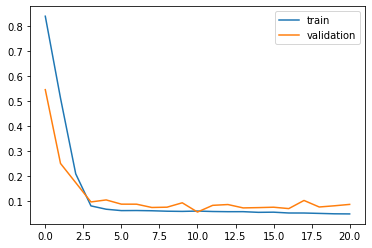


predict: [[30.46220884 21.01889258]]
real:      [[29.31728142 20.05416645]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.1386 - mean_squared_error: 1.6610 - val_loss: 0.7519 - val_mean_squared_error: 0.8200
Epoch 2/1000
 - 0s - loss: 0.4857 - mean_squared_error: 0.4365 - val_loss: 0.0445 - val_mean_squared_error: 0.0031
Epoch 3/1000
 - 0s - loss: 0.0979 - mean_squared_error: 0.0169 - val_loss: 0.0431 - val_mean_squared_error: 0.0019
Epoch 4/1000
 - 0s - loss: 0.0716 - mean_squared_error: 0.0086 - val_loss: 0.0994 - val_mean_squared_error: 0.0146
Epoch 5/1000
 - 0s - loss: 0.0621 - mean_squared_error: 0.0063 - val_loss: 0.0834 - val_mean_squared_error: 0.0092
Epoch 6/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.0806 - val_mean_squared_error: 0.0084
Epoch 7/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.0577 - val_mean_squared_error: 0.0044
Epoch 8/1000
 - 0s - loss: 0.0595 - mean_squared_error: 0.0058 - val_los

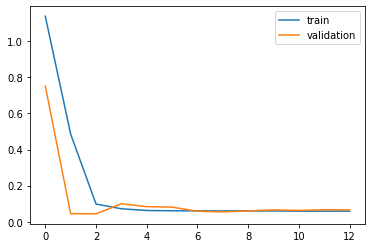


predict: [[29.92299366 22.08809485]]
real:      [[29.22178539 20.72263866]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6888 - mean_squared_error: 0.6383 - val_loss: 0.3588 - val_mean_squared_error: 0.1373
Epoch 2/1000
 - 0s - loss: 0.1712 - mean_squared_error: 0.0466 - val_loss: 0.1155 - val_mean_squared_error: 0.0140
Epoch 3/1000
 - 0s - loss: 0.0773 - mean_squared_error: 0.0096 - val_loss: 0.0691 - val_mean_squared_error: 0.0062
Epoch 4/1000
 - 0s - loss: 0.0649 - mean_squared_error: 0.0067 - val_loss: 0.0784 - val_mean_squared_error: 0.0094
Epoch 5/1000
 - 0s - loss: 0.0623 - mean_squared_error: 0.0063 - val_loss: 0.0855 - val_mean_squared_error: 0.0122
Epoch 6/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0060 - val_loss: 0.0793 - val_mean_squared_error: 0.0094
Epoch 7/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0058 - val_loss: 0.0779 - val_mean_squared_error: 0.0103
Epoch 8/1000
 - 0s - loss: 0.0588 - mean_squared_error: 0.0057 - val_los

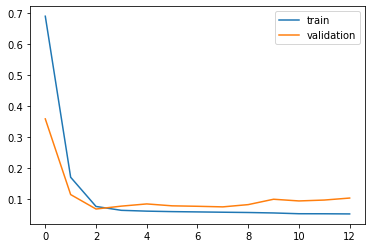


predict: [[30.4439119 21.3927048]]
real:      [[28.9352973  21.29561484]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5025 - mean_squared_error: 0.4313 - val_loss: 0.1774 - val_mean_squared_error: 0.0620
Epoch 2/1000
 - 0s - loss: 0.1043 - mean_squared_error: 0.0185 - val_loss: 0.0546 - val_mean_squared_error: 0.0034
Epoch 3/1000
 - 0s - loss: 0.0672 - mean_squared_error: 0.0074 - val_loss: 0.0272 - val_mean_squared_error: 0.0011
Epoch 4/1000
 - 0s - loss: 0.0624 - mean_squared_error: 0.0063 - val_loss: 0.0300 - val_mean_squared_error: 0.0017
Epoch 5/1000
 - 0s - loss: 0.0617 - mean_squared_error: 0.0061 - val_loss: 0.0538 - val_mean_squared_error: 0.0030
Epoch 6/1000
 - 0s - loss: 0.0625 - mean_squared_error: 0.0063 - val_loss: 0.0360 - val_mean_squared_error: 0.0019
Epoch 7/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0058 - val_loss: 0.0426 - val_mean_squared_error: 0.0025
Epoch 8/1000
 - 0s - loss: 0.0589 - mean_squared_error: 0.0057 - val_loss:

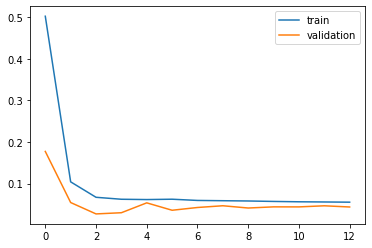


predict: [[30.62486183 22.08404571]]
real:      [[28.64880921 22.05958309]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5570 - mean_squared_error: 0.3941 - val_loss: 0.2687 - val_mean_squared_error: 0.0763
Epoch 2/1000
 - 0s - loss: 0.1206 - mean_squared_error: 0.0213 - val_loss: 0.0756 - val_mean_squared_error: 0.0057
Epoch 3/1000
 - 0s - loss: 0.0712 - mean_squared_error: 0.0080 - val_loss: 0.0511 - val_mean_squared_error: 0.0030
Epoch 4/1000
 - 0s - loss: 0.0634 - mean_squared_error: 0.0066 - val_loss: 0.0521 - val_mean_squared_error: 0.0041
Epoch 5/1000
 - 0s - loss: 0.0616 - mean_squared_error: 0.0063 - val_loss: 0.0504 - val_mean_squared_error: 0.0031
Epoch 6/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.0141 - val_mean_squared_error: 3.1184e-04
Epoch 7/1000
 - 0s - loss: 0.0619 - mean_squared_error: 0.0062 - val_loss: 0.0277 - val_mean_squared_error: 0.0010
Epoch 8/1000
 - 0s - loss: 0.0593 - mean_squared_error: 0.0058 - val

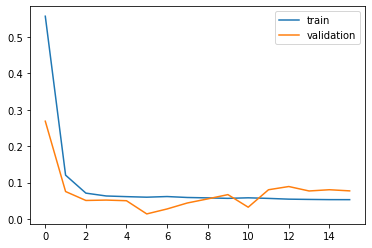


predict: [[30.04880506 20.9105908 ]]
real:      [[29.69926555 21.773095  ]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4759 - mean_squared_error: 0.3305 - val_loss: 0.2472 - val_mean_squared_error: 0.0695
Epoch 2/1000
 - 0s - loss: 0.1000 - mean_squared_error: 0.0160 - val_loss: 0.1106 - val_mean_squared_error: 0.0166
Epoch 3/1000
 - 0s - loss: 0.0724 - mean_squared_error: 0.0089 - val_loss: 0.0370 - val_mean_squared_error: 0.0023
Epoch 4/1000
 - 0s - loss: 0.0641 - mean_squared_error: 0.0069 - val_loss: 0.0242 - val_mean_squared_error: 8.7191e-04
Epoch 5/1000
 - 0s - loss: 0.0629 - mean_squared_error: 0.0066 - val_loss: 0.0222 - val_mean_squared_error: 8.5751e-04
Epoch 6/1000
 - 0s - loss: 0.0616 - mean_squared_error: 0.0062 - val_loss: 0.0392 - val_mean_squared_error: 0.0022
Epoch 7/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0060 - val_loss: 0.0396 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0059 -

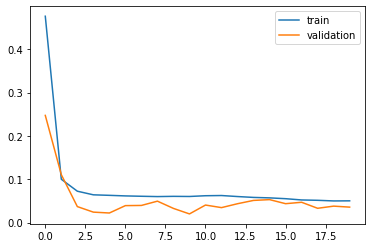


predict: [[29.76117224 21.57099575]]
real:      [[29.69926555 21.29561484]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8242 - mean_squared_error: 0.7612 - val_loss: 0.1684 - val_mean_squared_error: 0.0315
Epoch 2/1000
 - 0s - loss: 0.1177 - mean_squared_error: 0.0242 - val_loss: 0.0326 - val_mean_squared_error: 0.0013
Epoch 3/1000
 - 0s - loss: 0.0713 - mean_squared_error: 0.0081 - val_loss: 0.0544 - val_mean_squared_error: 0.0046
Epoch 4/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0063 - val_loss: 0.0794 - val_mean_squared_error: 0.0083
Epoch 5/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0062 - val_loss: 0.0807 - val_mean_squared_error: 0.0090
Epoch 6/1000
 - 0s - loss: 0.0602 - mean_squared_error: 0.0059 - val_loss: 0.0813 - val_mean_squared_error: 0.0073
Epoch 7/1000
 - 0s - loss: 0.0603 - mean_squared_error: 0.0059 - val_loss: 0.0769 - val_mean_squared_error: 0.0070
Epoch 8/1000
 - 0s - loss: 0.0606 - mean_squared_error: 0.0061 - val_los

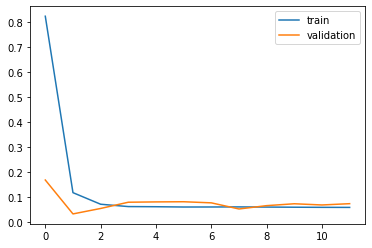


predict: [[30.13355386 20.92803848]]
real:      [[29.60376952 21.773095  ]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7759 - mean_squared_error: 0.8424 - val_loss: 0.4261 - val_mean_squared_error: 0.2020
Epoch 2/1000
 - 0s - loss: 0.1918 - mean_squared_error: 0.0561 - val_loss: 0.2254 - val_mean_squared_error: 0.1012
Epoch 3/1000
 - 0s - loss: 0.0820 - mean_squared_error: 0.0114 - val_loss: 0.1763 - val_mean_squared_error: 0.0585
Epoch 4/1000
 - 0s - loss: 0.0667 - mean_squared_error: 0.0074 - val_loss: 0.1443 - val_mean_squared_error: 0.0382
Epoch 5/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0063 - val_loss: 0.1164 - val_mean_squared_error: 0.0252
Epoch 6/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0063 - val_loss: 0.1148 - val_mean_squared_error: 0.0235
Epoch 7/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0059 - val_loss: 0.1332 - val_mean_squared_error: 0.0337
Epoch 8/1000
 - 0s - loss: 0.0595 - mean_squared_error: 0.0059 - val_los

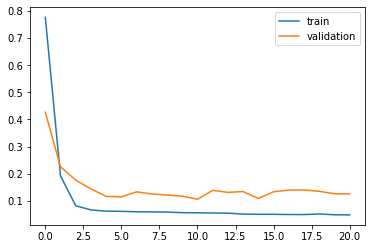


predict: [[29.43544669 21.34398372]]
real:      [[29.31728142 20.72263866]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7355 - mean_squared_error: 0.7179 - val_loss: 0.2374 - val_mean_squared_error: 0.1006
Epoch 2/1000
 - 0s - loss: 0.1489 - mean_squared_error: 0.0327 - val_loss: 0.1420 - val_mean_squared_error: 0.0202
Epoch 3/1000
 - 0s - loss: 0.0791 - mean_squared_error: 0.0100 - val_loss: 0.0754 - val_mean_squared_error: 0.0060
Epoch 4/1000
 - 0s - loss: 0.0685 - mean_squared_error: 0.0075 - val_loss: 0.0613 - val_mean_squared_error: 0.0066
Epoch 5/1000
 - 0s - loss: 0.0647 - mean_squared_error: 0.0067 - val_loss: 0.0745 - val_mean_squared_error: 0.0084
Epoch 6/1000
 - 0s - loss: 0.0621 - mean_squared_error: 0.0063 - val_loss: 0.0846 - val_mean_squared_error: 0.0140
Epoch 7/1000
 - 0s - loss: 0.0619 - mean_squared_error: 0.0063 - val_loss: 0.0852 - val_mean_squared_error: 0.0124
Epoch 8/1000
 - 0s - loss: 0.0622 - mean_squared_error: 0.0063 - val_los

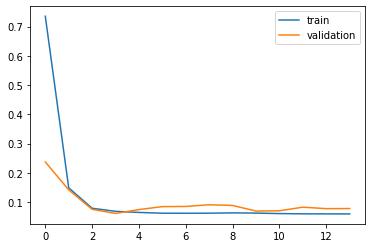


predict: [[29.59706085 21.6266221 ]]
real:      [[26.64339256 21.96408706]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4215 - mean_squared_error: 0.3337 - val_loss: 0.2040 - val_mean_squared_error: 0.0747
Epoch 2/1000
 - 0s - loss: 0.1045 - mean_squared_error: 0.0190 - val_loss: 0.1077 - val_mean_squared_error: 0.0229
Epoch 3/1000
 - 0s - loss: 0.0716 - mean_squared_error: 0.0086 - val_loss: 0.0809 - val_mean_squared_error: 0.0107
Epoch 4/1000
 - 0s - loss: 0.0634 - mean_squared_error: 0.0066 - val_loss: 0.0807 - val_mean_squared_error: 0.0098
Epoch 5/1000
 - 0s - loss: 0.0615 - mean_squared_error: 0.0063 - val_loss: 0.0604 - val_mean_squared_error: 0.0053
Epoch 6/1000
 - 0s - loss: 0.0602 - mean_squared_error: 0.0060 - val_loss: 0.0619 - val_mean_squared_error: 0.0046
Epoch 7/1000
 - 0s - loss: 0.0583 - mean_squared_error: 0.0057 - val_loss: 0.0616 - val_mean_squared_error: 0.0060
Epoch 8/1000
 - 0s - loss: 0.0570 - mean_squared_error: 0.0056 - val_los

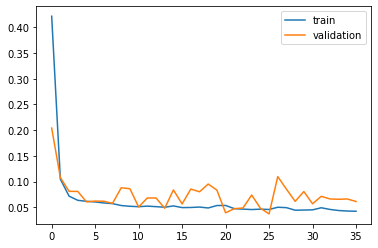


predict: [[30.45112806 20.56987307]]
real:      [[28.17132905 21.96408706]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8875 - mean_squared_error: 0.9649 - val_loss: 0.3368 - val_mean_squared_error: 0.1230
Epoch 2/1000
 - 0s - loss: 0.1809 - mean_squared_error: 0.0542 - val_loss: 0.1073 - val_mean_squared_error: 0.0219
Epoch 3/1000
 - 0s - loss: 0.0801 - mean_squared_error: 0.0110 - val_loss: 0.0670 - val_mean_squared_error: 0.0045
Epoch 4/1000
 - 0s - loss: 0.0682 - mean_squared_error: 0.0078 - val_loss: 0.0884 - val_mean_squared_error: 0.0100
Epoch 5/1000
 - 0s - loss: 0.0639 - mean_squared_error: 0.0068 - val_loss: 0.0968 - val_mean_squared_error: 0.0094
Epoch 6/1000
 - 0s - loss: 0.0638 - mean_squared_error: 0.0067 - val_loss: 0.1061 - val_mean_squared_error: 0.0115
Epoch 7/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0061 - val_loss: 0.0865 - val_mean_squared_error: 0.0075
Epoch 8/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0060 - val_los

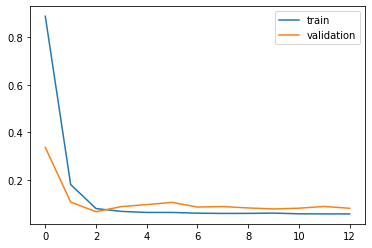


predict: [[29.82565007 20.45671333]]
real:      [[29.31728142 20.81813469]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8358 - mean_squared_error: 0.9015 - val_loss: 0.2808 - val_mean_squared_error: 0.1311
Epoch 2/1000
 - 0s - loss: 0.1268 - mean_squared_error: 0.0250 - val_loss: 0.1801 - val_mean_squared_error: 0.0371
Epoch 3/1000
 - 0s - loss: 0.0775 - mean_squared_error: 0.0098 - val_loss: 0.2380 - val_mean_squared_error: 0.0710
Epoch 4/1000
 - 0s - loss: 0.0636 - mean_squared_error: 0.0064 - val_loss: 0.2064 - val_mean_squared_error: 0.0623
Epoch 5/1000
 - 0s - loss: 0.0611 - mean_squared_error: 0.0061 - val_loss: 0.1907 - val_mean_squared_error: 0.0512
Epoch 6/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0060 - val_loss: 0.2044 - val_mean_squared_error: 0.0574
Epoch 7/1000
 - 0s - loss: 0.0586 - mean_squared_error: 0.0057 - val_loss: 0.1978 - val_mean_squared_error: 0.0538
Epoch 8/1000
 - 0s - loss: 0.0578 - mean_squared_error: 0.0056 - val_los

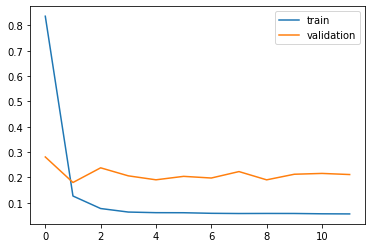


predict: [[29.78071526 23.30384455]]
real:      [[29.89025761 19.95867042]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.2259 - mean_squared_error: 1.6315 - val_loss: 0.8115 - val_mean_squared_error: 0.6771
Epoch 2/1000
 - 0s - loss: 0.6666 - mean_squared_error: 0.6007 - val_loss: 0.3092 - val_mean_squared_error: 0.1240
Epoch 3/1000
 - 0s - loss: 0.1659 - mean_squared_error: 0.0488 - val_loss: 0.2532 - val_mean_squared_error: 0.0642
Epoch 4/1000
 - 0s - loss: 0.0802 - mean_squared_error: 0.0100 - val_loss: 0.1287 - val_mean_squared_error: 0.0204
Epoch 5/1000
 - 0s - loss: 0.0651 - mean_squared_error: 0.0067 - val_loss: 0.1230 - val_mean_squared_error: 0.0177
Epoch 6/1000
 - 0s - loss: 0.0613 - mean_squared_error: 0.0061 - val_loss: 0.1748 - val_mean_squared_error: 0.0367
Epoch 7/1000
 - 0s - loss: 0.0585 - mean_squared_error: 0.0056 - val_loss: 0.1403 - val_mean_squared_error: 0.0213
Epoch 8/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0058 - val_los

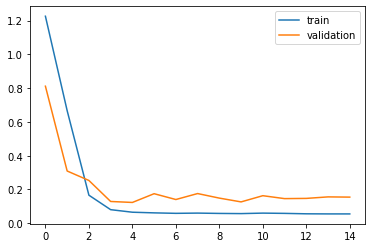


predict: [[31.02466233 20.14203697]]
real:      [[24.73347195 20.24515851]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9476 - mean_squared_error: 1.0913 - val_loss: 0.5162 - val_mean_squared_error: 0.3343
Epoch 2/1000
 - 0s - loss: 0.3402 - mean_squared_error: 0.2054 - val_loss: 0.0780 - val_mean_squared_error: 0.0064
Epoch 3/1000
 - 0s - loss: 0.0931 - mean_squared_error: 0.0150 - val_loss: 0.0911 - val_mean_squared_error: 0.0085
Epoch 4/1000
 - 0s - loss: 0.0693 - mean_squared_error: 0.0076 - val_loss: 0.0965 - val_mean_squared_error: 0.0115
Epoch 5/1000
 - 0s - loss: 0.0645 - mean_squared_error: 0.0067 - val_loss: 0.0936 - val_mean_squared_error: 0.0101
Epoch 6/1000
 - 0s - loss: 0.0630 - mean_squared_error: 0.0066 - val_loss: 0.0739 - val_mean_squared_error: 0.0065
Epoch 7/1000
 - 0s - loss: 0.0619 - mean_squared_error: 0.0062 - val_loss: 0.0882 - val_mean_squared_error: 0.0086
Epoch 8/1000
 - 0s - loss: 0.0611 - mean_squared_error: 0.0061 - val_los

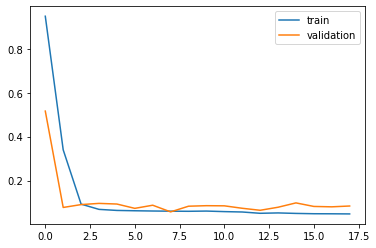


predict: [[30.32852159 20.20266788]]
real:      [[27.88484096 20.14966248]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8421 - mean_squared_error: 1.0372 - val_loss: 0.4467 - val_mean_squared_error: 0.3748
Epoch 2/1000
 - 0s - loss: 0.5063 - mean_squared_error: 0.4683 - val_loss: 0.2167 - val_mean_squared_error: 0.0873
Epoch 3/1000
 - 0s - loss: 0.2179 - mean_squared_error: 0.0934 - val_loss: 0.1330 - val_mean_squared_error: 0.0260
Epoch 4/1000
 - 0s - loss: 0.0848 - mean_squared_error: 0.0125 - val_loss: 0.1320 - val_mean_squared_error: 0.0281
Epoch 5/1000
 - 0s - loss: 0.0740 - mean_squared_error: 0.0085 - val_loss: 0.1133 - val_mean_squared_error: 0.0232
Epoch 6/1000
 - 0s - loss: 0.0672 - mean_squared_error: 0.0073 - val_loss: 0.1375 - val_mean_squared_error: 0.0279
Epoch 7/1000
 - 0s - loss: 0.0645 - mean_squared_error: 0.0068 - val_loss: 0.1181 - val_mean_squared_error: 0.0247
Epoch 8/1000
 - 0s - loss: 0.0641 - mean_squared_error: 0.0067 - val_los

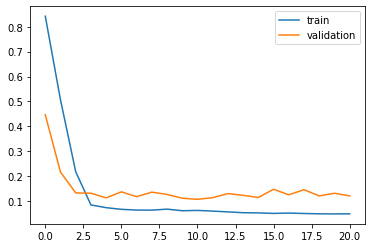


predict: [[30.84997061 21.27886388]]
real:      [[29.69926555 20.72263866]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8242 - mean_squared_error: 0.9125 - val_loss: 0.3393 - val_mean_squared_error: 0.1324
Epoch 2/1000
 - 0s - loss: 0.1938 - mean_squared_error: 0.0728 - val_loss: 0.1723 - val_mean_squared_error: 0.0396
Epoch 3/1000
 - 0s - loss: 0.0949 - mean_squared_error: 0.0135 - val_loss: 0.0840 - val_mean_squared_error: 0.0072
Epoch 4/1000
 - 0s - loss: 0.0693 - mean_squared_error: 0.0076 - val_loss: 0.0882 - val_mean_squared_error: 0.0089
Epoch 5/1000
 - 0s - loss: 0.0693 - mean_squared_error: 0.0075 - val_loss: 0.0891 - val_mean_squared_error: 0.0099
Epoch 6/1000
 - 0s - loss: 0.0651 - mean_squared_error: 0.0068 - val_loss: 0.0366 - val_mean_squared_error: 0.0016
Epoch 7/1000
 - 0s - loss: 0.0652 - mean_squared_error: 0.0067 - val_loss: 0.0332 - val_mean_squared_error: 0.0020
Epoch 8/1000
 - 0s - loss: 0.0621 - mean_squared_error: 0.0062 - val_los

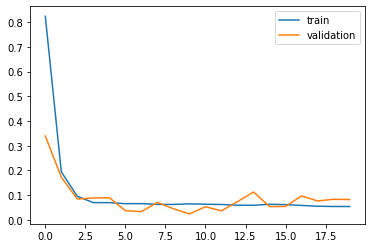


predict: [[29.23847966 20.75078257]]
real:      [[27.40736081 22.15507912]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9864 - mean_squared_error: 1.2007 - val_loss: 0.3673 - val_mean_squared_error: 0.2402
Epoch 2/1000
 - 0s - loss: 0.2206 - mean_squared_error: 0.0921 - val_loss: 0.1650 - val_mean_squared_error: 0.0528
Epoch 3/1000
 - 0s - loss: 0.0925 - mean_squared_error: 0.0142 - val_loss: 0.0713 - val_mean_squared_error: 0.0082
Epoch 4/1000
 - 0s - loss: 0.0689 - mean_squared_error: 0.0082 - val_loss: 0.0456 - val_mean_squared_error: 0.0023
Epoch 5/1000
 - 0s - loss: 0.0610 - mean_squared_error: 0.0063 - val_loss: 0.0492 - val_mean_squared_error: 0.0031
Epoch 6/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0057 - val_loss: 0.0524 - val_mean_squared_error: 0.0032
Epoch 7/1000
 - 0s - loss: 0.0582 - mean_squared_error: 0.0056 - val_loss: 0.0451 - val_mean_squared_error: 0.0025
Epoch 8/1000
 - 0s - loss: 0.0577 - mean_squared_error: 0.0055 - val_los

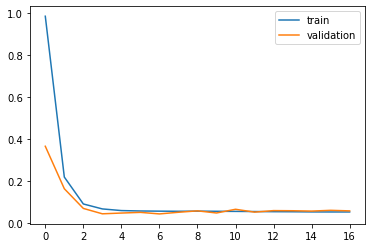


predict: [[30.1512543  21.22770624]]
real:      [[29.79476158 21.29561484]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.9199 - mean_squared_error: 1.0668 - val_loss: 0.3150 - val_mean_squared_error: 0.1419
Epoch 2/1000
 - 0s - loss: 0.2694 - mean_squared_error: 0.0971 - val_loss: 0.0843 - val_mean_squared_error: 0.0075
Epoch 3/1000
 - 0s - loss: 0.0857 - mean_squared_error: 0.0123 - val_loss: 0.1251 - val_mean_squared_error: 0.0179
Epoch 4/1000
 - 0s - loss: 0.0718 - mean_squared_error: 0.0083 - val_loss: 0.0501 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 0s - loss: 0.0658 - mean_squared_error: 0.0070 - val_loss: 0.0873 - val_mean_squared_error: 0.0131
Epoch 6/1000
 - 0s - loss: 0.0625 - mean_squared_error: 0.0065 - val_loss: 0.0645 - val_mean_squared_error: 0.0073
Epoch 7/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0061 - val_loss: 0.0596 - val_mean_squared_error: 0.0064
Epoch 8/1000
 - 0s - loss: 0.0592 - mean_squared_error: 0.0058 - val_los

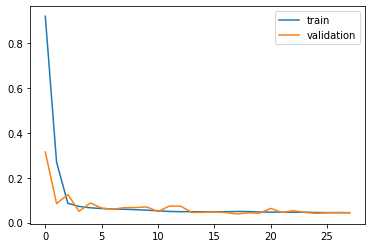


predict: [[29.56073741 20.94974383]]
real:      [[29.69926555 21.29561484]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6739 - mean_squared_error: 0.6695 - val_loss: 0.1977 - val_mean_squared_error: 0.0406
Epoch 2/1000
 - 0s - loss: 0.1401 - mean_squared_error: 0.0327 - val_loss: 0.0690 - val_mean_squared_error: 0.0063
Epoch 3/1000
 - 0s - loss: 0.0898 - mean_squared_error: 0.0130 - val_loss: 0.1054 - val_mean_squared_error: 0.0162
Epoch 4/1000
 - 0s - loss: 0.0638 - mean_squared_error: 0.0067 - val_loss: 0.0569 - val_mean_squared_error: 0.0042
Epoch 5/1000
 - 0s - loss: 0.0606 - mean_squared_error: 0.0061 - val_loss: 0.0363 - val_mean_squared_error: 0.0015
Epoch 6/1000
 - 0s - loss: 0.0595 - mean_squared_error: 0.0059 - val_loss: 0.0374 - val_mean_squared_error: 0.0027
Epoch 7/1000
 - 0s - loss: 0.0597 - mean_squared_error: 0.0058 - val_loss: 0.0397 - val_mean_squared_error: 0.0031
Epoch 8/1000
 - 0s - loss: 0.0586 - mean_squared_error: 0.0056 - val_los

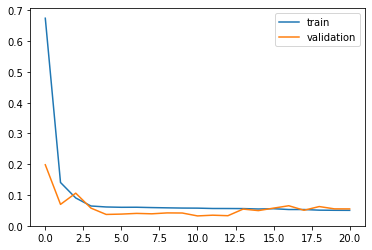


predict: [[30.17075689 21.5773399 ]]
real:      [[29.60376952 21.773095  ]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6051 - mean_squared_error: 0.4719 - val_loss: 0.3541 - val_mean_squared_error: 0.1571
Epoch 2/1000
 - 0s - loss: 0.1193 - mean_squared_error: 0.0277 - val_loss: 0.0546 - val_mean_squared_error: 0.0057
Epoch 3/1000
 - 0s - loss: 0.0736 - mean_squared_error: 0.0088 - val_loss: 0.0996 - val_mean_squared_error: 0.0127
Epoch 4/1000
 - 0s - loss: 0.0666 - mean_squared_error: 0.0073 - val_loss: 0.0589 - val_mean_squared_error: 0.0054
Epoch 5/1000
 - 0s - loss: 0.0638 - mean_squared_error: 0.0067 - val_loss: 0.0678 - val_mean_squared_error: 0.0072
Epoch 6/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0062 - val_loss: 0.0597 - val_mean_squared_error: 0.0054
Epoch 7/1000
 - 0s - loss: 0.0597 - mean_squared_error: 0.0059 - val_loss: 0.0637 - val_mean_squared_error: 0.0072
Epoch 8/1000
 - 0s - loss: 0.0595 - mean_squared_error: 0.0058 - val_los

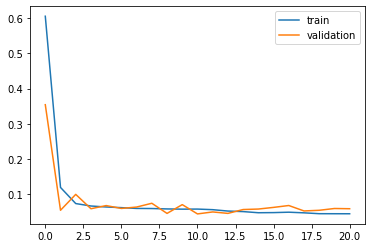


predict: [[29.35370315 20.61220324]]
real:      [[30.08124967 21.96408706]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.0036 - mean_squared_error: 1.2343 - val_loss: 0.1663 - val_mean_squared_error: 0.0364
Epoch 2/1000
 - 0s - loss: 0.1564 - mean_squared_error: 0.0363 - val_loss: 0.0804 - val_mean_squared_error: 0.0097
Epoch 3/1000
 - 0s - loss: 0.0854 - mean_squared_error: 0.0110 - val_loss: 0.1002 - val_mean_squared_error: 0.0161
Epoch 4/1000
 - 0s - loss: 0.0688 - mean_squared_error: 0.0079 - val_loss: 0.0418 - val_mean_squared_error: 0.0024
Epoch 5/1000
 - 0s - loss: 0.0627 - mean_squared_error: 0.0063 - val_loss: 0.0625 - val_mean_squared_error: 0.0072
Epoch 6/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0058 - val_loss: 0.0538 - val_mean_squared_error: 0.0055
Epoch 7/1000
 - 0s - loss: 0.0595 - mean_squared_error: 0.0058 - val_loss: 0.0548 - val_mean_squared_error: 0.0059
Epoch 8/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0059 - val_los

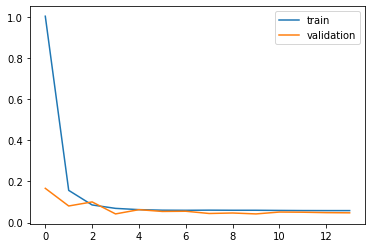


predict: [[30.94504951 21.98697763]]
real:      [[29.50827348 21.86859103]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6778 - mean_squared_error: 0.6278 - val_loss: 0.2020 - val_mean_squared_error: 0.0502
Epoch 2/1000
 - 0s - loss: 0.1290 - mean_squared_error: 0.0249 - val_loss: 0.0445 - val_mean_squared_error: 0.0035
Epoch 3/1000
 - 0s - loss: 0.0684 - mean_squared_error: 0.0073 - val_loss: 0.0646 - val_mean_squared_error: 0.0046
Epoch 4/1000
 - 0s - loss: 0.0612 - mean_squared_error: 0.0061 - val_loss: 0.0641 - val_mean_squared_error: 0.0041
Epoch 5/1000
 - 0s - loss: 0.0589 - mean_squared_error: 0.0057 - val_loss: 0.0860 - val_mean_squared_error: 0.0074
Epoch 6/1000
 - 0s - loss: 0.0578 - mean_squared_error: 0.0055 - val_loss: 0.0644 - val_mean_squared_error: 0.0042
Epoch 7/1000
 - 0s - loss: 0.0565 - mean_squared_error: 0.0053 - val_loss: 0.0840 - val_mean_squared_error: 0.0074
Epoch 8/1000
 - 0s - loss: 0.0547 - mean_squared_error: 0.0051 - val_los

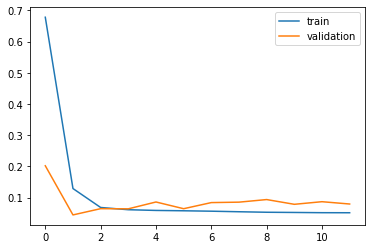


predict: [[30.67576924 20.12116572]]
real:      [[29.79476158 22.15507912]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6694 - mean_squared_error: 0.6306 - val_loss: 0.2481 - val_mean_squared_error: 0.0994
Epoch 2/1000
 - 0s - loss: 0.1386 - mean_squared_error: 0.0291 - val_loss: 0.1543 - val_mean_squared_error: 0.0380
Epoch 3/1000
 - 0s - loss: 0.0856 - mean_squared_error: 0.0111 - val_loss: 0.1618 - val_mean_squared_error: 0.0305
Epoch 4/1000
 - 0s - loss: 0.0672 - mean_squared_error: 0.0069 - val_loss: 0.1100 - val_mean_squared_error: 0.0205
Epoch 5/1000
 - 0s - loss: 0.0627 - mean_squared_error: 0.0062 - val_loss: 0.0992 - val_mean_squared_error: 0.0179
Epoch 6/1000
 - 0s - loss: 0.0626 - mean_squared_error: 0.0063 - val_loss: 0.0923 - val_mean_squared_error: 0.0152
Epoch 7/1000
 - 0s - loss: 0.0617 - mean_squared_error: 0.0061 - val_loss: 0.0998 - val_mean_squared_error: 0.0180
Epoch 8/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0058 - val_los

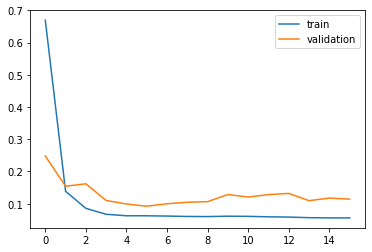


predict: [[30.14479894 21.87660199]]
real:      [[29.60376952 20.14966248]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7782 - mean_squared_error: 0.6994 - val_loss: 0.4189 - val_mean_squared_error: 0.2035
Epoch 2/1000
 - 0s - loss: 0.1950 - mean_squared_error: 0.0635 - val_loss: 0.1294 - val_mean_squared_error: 0.0172
Epoch 3/1000
 - 0s - loss: 0.0901 - mean_squared_error: 0.0123 - val_loss: 0.1236 - val_mean_squared_error: 0.0168
Epoch 4/1000
 - 0s - loss: 0.0695 - mean_squared_error: 0.0075 - val_loss: 0.0813 - val_mean_squared_error: 0.0112
Epoch 5/1000
 - 0s - loss: 0.0627 - mean_squared_error: 0.0063 - val_loss: 0.0729 - val_mean_squared_error: 0.0088
Epoch 6/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0061 - val_loss: 0.0732 - val_mean_squared_error: 0.0096
Epoch 7/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0060 - val_loss: 0.0725 - val_mean_squared_error: 0.0104
Epoch 8/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0058 - val_los

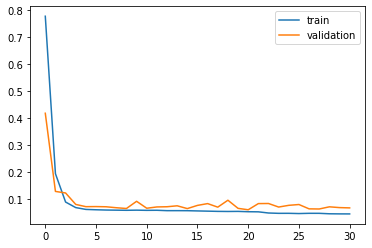


predict: [[29.59793791 20.53500803]]
real:      [[27.40736081 21.773095  ]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3109 - mean_squared_error: 0.1569 - val_loss: 0.1680 - val_mean_squared_error: 0.0427
Epoch 2/1000
 - 0s - loss: 0.0880 - mean_squared_error: 0.0123 - val_loss: 0.1179 - val_mean_squared_error: 0.0160
Epoch 3/1000
 - 0s - loss: 0.0717 - mean_squared_error: 0.0084 - val_loss: 0.0524 - val_mean_squared_error: 0.0031
Epoch 4/1000
 - 0s - loss: 0.0648 - mean_squared_error: 0.0066 - val_loss: 0.0476 - val_mean_squared_error: 0.0032
Epoch 5/1000
 - 0s - loss: 0.0628 - mean_squared_error: 0.0063 - val_loss: 0.0676 - val_mean_squared_error: 0.0056
Epoch 6/1000
 - 0s - loss: 0.0615 - mean_squared_error: 0.0061 - val_loss: 0.0529 - val_mean_squared_error: 0.0035
Epoch 7/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0060 - val_loss: 0.0723 - val_mean_squared_error: 0.0063
Epoch 8/1000
 - 0s - loss: 0.0606 - mean_squared_error: 0.0059 - val_los

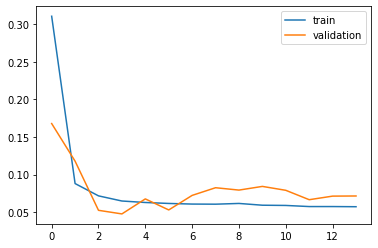


predict: [[30.23853318 21.09877332]]
real:      [[28.74430524 21.86859103]]

Test RMSE -------------------------- 2.356
Test VARIANCE ---------------------- 1.0
Test MAX-ERROR --------------------- 3.218
Test MEAN-ABSOLUTE-ERROR ----------- 2.041
Test MEDIAN-ABSOLUTE-ERROR --------- 2.041


In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

mean_scaler = np.mean(values)
dataset_scaled = dataset.div(mean_scaler+1)

NCV(dataset_scaled, days_to_predict, mean_scaler)